# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [1]:
# Surprise documentation
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html
import pandas  as pd
import numpy   as np
import seaborn 

from surprise                 import Dataset, Reader
from surprise                 import NormalPredictor, BaselineOnly
from surprise                 import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise                 import SVD, SVDpp, NMF
from surprise                 import SlopeOne
from surprise                 import CoClustering
from surprise.accuracy        import rmse
from surprise.model_selection import cross_validate, train_test_split

from sklearn.neighbors        import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

from scipy.sparse             import csr_matrix # This is to create sparse matrixes

In [2]:
# Este solo tiene las bandas con los ids
artist_data = pd.read_csv("artists.dat", sep="\t")
print(artist_data.head())

   id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...  


In [3]:
user_artist_plays = pd.read_csv("user_artists.dat", sep="\t")
print (user_artist_plays.head())
print (user_artist_plays.shape)

   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983
(92834, 3)


## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

Cuales son los artistas mas escuchados

In [4]:
# Agrupamos por Id de banda y sumamos la cantidad de veces que fueron escuchados.
sum_listened_artist = user_artist_plays.groupby(["artistID"]).sum()
sum_listened_artist = sum_listened_artist.sort_values(ascending = False, by = 'weight')
sum_listened_artist = sum_listened_artist.drop(columns = ['userID'])
sum_listened_artist

,weight
artistID,
289,2393140
72,1301308
89,1291387
292,1058405
498,963449
...,...
17468,1
14309,1
14308,1


In [5]:
# Seleccionamos los tops artists
select_top_artists = 10
top_artist         = sum_listened_artist.head(select_top_artists)
top_artist

,weight
artistID,
289,2393140
72,1301308
89,1291387
292,1058405
498,963449
67,921198
288,905423
701,688529
227,662116


In [6]:
# Mostramos los nombres los artistas.
top_artist         = sum_listened_artist.head(select_top_artists)
top_artists_id     = top_artist.index.values
ranking            = 1
for artist_id in top_artists_id:
    name     = artist_data.loc[artist_data['id'] == artist_id].name.values[0]
    id       = artist_data.loc[artist_data['id'] == artist_id].id.values[0]
    to_print = "%2s %25s %6s" % (ranking, name, id) 
    print (to_print)
    ranking += 1

 1            Britney Spears    289
 2              Depeche Mode     72
 3                 Lady Gaga     89
 4        Christina Aguilera    292
 5                  Paramore    498
 6                   Madonna     67
 7                   Rihanna    288
 8                   Shakira    701
 9               The Beatles    227
10                Katy Perry    300


¿Cómo es la distribución de cantidad de listens por user?

      userID  artistID  weight
3764      80       768       7
3765      80       779     245
3766      80       805    1170
3767      80       813     281
3768      80       815       7


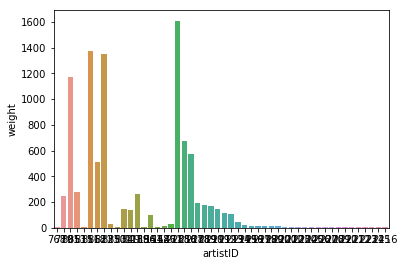

In [7]:
# Hay que examinar por user como es que se distrubuye la cantidad de listen por artista ? [FIXME] preguntar bien que onda esta pregunta.
selected_user = 80
selected_user_data = user_artist_plays[user_artist_plays.userID == selected_user]
print (selected_user_data.head(5))
seaborn.barplot(x = 'artistID', y = 'weight', data = selected_user_data)

# Depende del user.
# Algunos tienen un artista que escuchan solo ese y despues nada mas. 
# Mientras que otros un top que escuchan similar.

¿Es posible ver el género más escuchado?

In [8]:
tags_data = pd.read_csv("tags.dat", sep="\t", encoding = "ISO-8859-1")
print (tags_data.tagValue.unique())
tags_data.head(10)

['metal' 'alternative metal' 'goth rock' ... 'sverige' 'eire'
 'electro latino']


,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
5,6,industrial metal
6,7,gothic metal
7,8,terror ebm
8,9,electro-industrial
9,10,harsh ebm


En este archivo tags, pareciera que estan los generos, pero son demasiados distintos para poder considerarlos como categorias. Segun yo no puede haber tantos generos musicales.

## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [9]:
# Creamos la matriz de usuario contenido.
matrix = user_artist_plays.pivot_table(index = 'userID', columns = 'artistID', values = 'weight').fillna(0)

In [10]:
matrix.head()

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Debemos normalizar los rating implicitos a explicitos
# Dividiendo los weights por el maximo de cada usuario.

# Get the max amount of listens per user.
max_per_user_array = matrix.max(axis = 1).values

# Divide each value per user to get and explicit rating.
explicit_rating_matrix = matrix.divide(max_per_user_array, axis = 0)

In [61]:
explicit_rating_matrix.head()

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Its better explained here
# https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

min_weight = explicit_rating_matrix.min(axis=1).unique()[0]
max_weight = explicit_rating_matrix.max(axis=1).unique()[0]

print (min_weight) 
print (max_weight)

# [FIXME] The object reader from suprise, works with ratings between 0 - 1
# Maybe we need to scale the ratings a bit.

0.0
1.0


In [14]:
# explicit_rating_matrix
# reader     = Reader(rating_scale = (min_weight, max_weight))
# ratings    = Dataset.load_from_df(explicit_rating_matrix, reader)

In [15]:
# It turns out that we dont actually need a matrix, because the library we are trying to use doesnt support a matrix
# Or maybe we just using it wrong.
# So we will build the 'matrix' by adjusting the ratings provided, instead of actually building a matrix.

scaling_rating_factor = 5

max_by_user = user_artist_plays.groupby(['userID']).weight.max()

for user in user_artist_plays.userID.unique():
    user_artist_plays.loc[user_artist_plays.userID == user, 'weight'] = round ( user_artist_plays[user_artist_plays.userID == user].weight / max_by_user[user] * scaling_rating_factor, 2 )

# [FIXME] There has to be a better, optimized way to do this 

In [62]:
user_artist_plays.head()

,userID,artistID,weight
0,2,51,5.00
1,2,52,4.21
2,2,53,4.09
3,2,54,3.71
4,2,55,3.24


In [17]:
# We are going to define 2 functions that will come in handy at a later time.
# Generates a sparse matrix from ratings dataframe.
# Args:
#     df: pandas dataframe containing 3 columns (user, item, rating)
# Returns:
#     X: sparse matrix
#     user_mapper      : dict that maps user id's to user indices
#     user_inv_mapper  : dict that maps user indices to user id's
#     artist_mapper    : dict that maps artist id's to movie indices
#     artist_inv_mapper: dict that maps artist indices to movie id's
def create_spare_matrixes(df):
    
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper       = dict(zip(np.unique(df["userID"]), list(range(M))))
    artist_mapper     = dict(zip(np.unique(df["artistID"]), list(range(N))))
    
    user_inv_mapper   = dict(zip(list(range(M)), np.unique(df["userID"])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))
    
    user_index        = [user_mapper[i] for i in df['userID']]
    artist_index      = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["weight"], (user_index,artist_index)), shape=(M,N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

In [18]:
# Now we are going to create all the necesary matrixes to build the recomender system later.
sparse_matrix, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_spare_matrixes(user_artist_plays)

In [19]:
min_rating, max_rating = user_artist_plays.weight.min(), user_artist_plays.weight.max()
print (min_rating, max_rating)

0.0 5.0


In [20]:
# We prepare the objects necessary to train the recommender system
reader  = Reader(rating_scale=(min_rating, max_rating))
ratings = Dataset.load_from_df(user_artist_plays[["userID",'artistID','weight']], reader)

In [21]:
# Split the data between train and test.
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2)

In [22]:
model       = KNNWithMeans(k=5).fit(ratings_train)
predictions = model.test(ratings_test)

print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.9768


In [23]:
# Normal Predictor -> preditcs a random rating based on the distribution of the training set, which is assumed to be normal. One of the most basic algorithms
# Baseline Only    -> Predicts teh baseline estimate for given user and item
# KNN Basic        -> Basic collaborative filtering algorithm
# KNN With means   -> Same as basic but it takes into account the mean ratings of each user
# KNN With Z scores-> Same but it takes the z-score normaliztion of each user. Requieres knowing the mean and std deviation from each user.
# KNN Baseline     -> Same but it takes into account the baseline rating
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, ratings, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.872742,29.201167,1.258423
SVD,0.878729,3.672188,0.207628
BaselineOnly,0.882521,0.217612,0.227961
KNNBaseline,0.920476,0.635818,3.134242
KNNWithMeans,0.937239,0.411916,2.297411
SlopeOne,0.950642,4.187191,1.002672
KNNWithZScore,0.952199,0.470985,2.403438
NMF,1.002821,5.208029,0.247318
CoClustering,1.026244,2.528688,0.198035


In [24]:
# The best RSME was achieved with KNN Basic so that will our choosen algorithm

# [FIXME] Do a grid search here to tune hiper parameters
collaborative_filter_model = KNNBasic(k=10).fit(ratings_train)
predictions                = collaborative_filter_model.test(ratings_test)

print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 1.0386


In [25]:
predictions_dataframe = pd.DataFrame(predictions, columns=['userID', 'artistID', 'actual_rating', 'predicted_rating', 'details'])

In [26]:
predictions_dataframe.head()

,userID,artistID,actual_rating,predicted_rating,details
0,784,3411,0.87,0.861037,"{'actual_k': 10, 'was_impossible': False}"
1,1910,5836,0.61,0.187195,"{'actual_k': 4, 'was_impossible': False}"
2,258,306,0.05,0.252120,"{'actual_k': 10, 'was_impossible': False}"
3,963,1062,0.01,0.774338,"{'actual_k': 10, 'was_impossible': False}"
4,1109,465,0.32,0.471884,"{'actual_k': 10, 'was_impossible': False}"


In [27]:
# This way we locate a specific artist with its name
artist_data.loc[artist_data.name == 'Bella Morte']

,id,name,url,pictureURL
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [28]:
# Finds k-nearest neighbours for a given movie id.
# Args:
#     artist_name: Will find artist similar to this.
#     X: sparse_matrix.
#     n_similar_artists: number of similar movies to retrieve
#     metric: distance metric used to meassure artist similarity

# Output: returns list of n_similar_artists similar artists

def find_similar_artists(artist_name, sparse_matrix, artist_mapper, artist_inv_mapper, n_similar_artists = 10):
# def find_similar_artists(artist_name):
    
    sparse_matrix = sparse_matrix.T
    
    neighbour_ids = []
    artist_id     = int(artist_data.loc[artist_data.name == artist_name].id)
    artist_index  = artist_mapper[artist_id]
    artist_vector = sparse_matrix[artist_index]

    if isinstance(artist_vector, (np.ndarray)):
        artist_vector = artist_vector.reshape(1,-1)
  
    # use k+1 since kNN output includes the movieId of interest
    KNN = NearestNeighbors(n_neighbors = n_similar_artists + 1, algorithm = "brute", metric = "cosine")
    KNN.fit(sparse_matrix)
    
    neighbour = KNN.kneighbors(artist_vector, return_distance=False) #[FIXME] Should we be using the other model, that gave us better metrics ? 
    
    for i in range(0,n_similar_artists + 1):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
    
    neighbour_ids.pop(0) # Its the elemet itself
    
    for id in neighbour_ids:
        print (artist_data.loc[artist_data.id == id].name.item())

In [65]:
find_similar_artists('Laura Pausini', sparse_matrix,artist_mapper,artist_inv_mapper)

Michael Bolton
Nana Mouskouri
Tina Turner
The Calling
Ventania
Ira!
Kazaky
Artists For Haiti
Luis Fonsi
Édith Piaf


<!-- ### Ejercicio 2b - Sistemas de Recomendación Avanzados -->

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

1) Evaluacion sobre el cold start, dejamos afuera algunos artistas.

In [30]:
# Cuales son los top artists, que pasa si removemos esos ?
# Capaz se pierdan muchos datos, capaz eliminando al azar de varias partes del raking rinde mas.
select_top_artists = 10
top_artist         = sum_listened_artist.head(select_top_artists)
top_artists_id     = top_artist.index.values
ranking            = 1
for artist_id in top_artists_id:
    name     = artist_data.loc[artist_data['id'] == artist_id].name.values[0]
    id       = artist_data.loc[artist_data['id'] == artist_id].id.values[0]
    to_print = "%2s %25s %6s" % (ranking, name, id) 
    print (to_print)
    ranking += 1

 1            Britney Spears    289
 2              Depeche Mode     72
 3                 Lady Gaga     89
 4        Christina Aguilera    292
 5                  Paramore    498
 6                   Madonna     67
 7                   Rihanna    288
 8                   Shakira    701
 9               The Beatles    227
10                Katy Perry    300


In [31]:
find_similar_artists('Christina Aguilera', sparse_matrix,artist_mapper,artist_inv_mapper)

Britney Spears
Rihanna
P!nk
Beyoncé
Katy Perry
The Pussycat Dolls
Lady Gaga
Ke$ha
Madonna
Kylie Minogue


In [32]:
find_similar_artists('Paramore', sparse_matrix,artist_mapper,artist_inv_mapper)

Flyleaf
Avril Lavigne
Good Charlotte
30 Seconds to Mars
Katy Perry
Eyes Set to Kill
Evanescence
Under Line
The Runaways
VersaEmerge


In [33]:
# Removing Artists
not_all_artists_df  = pd.read_csv("user_artists.dat", sep="\t")
# n_aritist_to_remove = 3
# for artist in top_artists_id[:n_aritist_to_remove]:
#     print("Removing artist %d" % artist)
#     not_all_artists_df = not_all_artists_df.drop( not_all_artists_df[not_all_artists_df.artistID == artist].index ) 


In [34]:
# Are they removed ? The ranking should've change.
sum_listened_artist = not_all_artists_df.groupby(["artistID"]).sum()
sum_listened_artist = sum_listened_artist.sort_values(ascending = False, by = 'weight')
sum_listened_artist = sum_listened_artist.drop(columns = ['userID'])
sum_listened_artist.head(10)

,weight
artistID,
289,2393140
72,1301308
89,1291387
292,1058405
498,963449
67,921198
288,905423
701,688529
227,662116


2) Generamos vectores de contenido.

In [77]:
# These files contain the tag assignments of artists provided by each particular user.
# They also contain the timestamps when the tag assignments were done.
user_tags_artirts = pd.read_csv("user_taggedartists.dat", sep="\t")
user_tags_artirts.head(10)

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
5,2,63,13,1,4,2009
6,2,63,14,1,4,2009
7,2,63,23,1,4,2009
8,2,63,40,1,4,2009
9,2,73,13,1,4,2009


In [78]:
# This file contains the set of tags available in the dataset
tags              = pd.read_csv("tags.dat", sep="\t", encoding='latin-1')
tags.head(10)

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
5,6,industrial metal
6,7,gothic metal
7,8,terror ebm
8,9,electro-industrial
9,10,harsh ebm


In [95]:
# Merging dataframe for easy access
# how left: use only keys from left frame, similar to a SQL left outer join; preserve key order.
# Column or index level names to join on. These must be found in both DataFrames. If on is None and not merging on indexes then this defaults to the intersection of the columns in both DataFrames.

content_df = user_tags_artirts.merge(tags, how='left', on=["tagID"])
content_df = content_df.drop(columns=['userID','day', 'month', 'year'])
content_df = content_df.drop_duplicates()
content_df.head(10)

,artistID,tagID,tagValue
0,52,13,chillout
1,52,15,downtempo
2,52,18,electronic
3,52,21,trip-hop
4,52,41,female vovalists
5,63,13,chillout
6,63,14,ambient
7,63,23,new age
8,63,40,gregorian chant
9,73,13,chillout


In [96]:
content_df[content_df.artistID == 3]

,artistID,tagID,tagValue
7781,3,4,black metal
54979,3,2092,norwegian black metal
54980,3,3706,true norwegian black metal
54981,3,4117,very kvlt
54982,3,4122,norsk arysk metal
137945,3,8882,saxophones


In [97]:
# Combine, diferent artist by its tag.
artists_and_tags = content_df.groupby(['artistID'])['tagID'].apply(lambda x: ','.join(x.astype(str))).reset_index()
artists_and_tags.head()

,artistID,tagID
0,1,"552,1219,139,141,2850,179,541"
1,2,"30,127,575,61,179,14,233,727,18,10137,190"
2,3,"4,2092,3706,4117,4122,8882"
3,4,"139,141,1,7561,9640,73,179,541,7"
4,5,"179,190,575,612,1097"


In [98]:
# Renaming so we can merge easily the name of the artist
artist_data = artist_data.rename(columns={'id' : 'artistID'})
artist_data.head()

,artistID,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [99]:
# Merging the artist name.
artists_and_tags = artists_and_tags.merge(artist_data, how='left', on=['artistID']).drop(columns=['url', 'pictureURL'])
artists_and_tags.head()

,artistID,tagID,name
0,1,"552,1219,139,141,2850,179,541",MALICE MIZER
1,2,"30,127,575,61,179,14,233,727,18,10137,190",Diary of Dreams
2,3,"4,2092,3706,4117,4122,8882",Carpathian Forest
3,4,"139,141,1,7561,9640,73,179,541,7",Moi dix Mois
4,5,"179,190,575,612,1097",Bella Morte


In [100]:
# Reordering the columns
artists_and_tags = artists_and_tags[['artistID','name','tagID']]
artists_and_tags.head()

,artistID,name,tagID
0,1,MALICE MIZER,"552,1219,139,141,2850,179,541"
1,2,Diary of Dreams,"30,127,575,61,179,14,233,727,18,10137,190"
2,3,Carpathian Forest,"4,2092,3706,4117,4122,8882"
3,4,Moi dix Mois,"139,141,1,7561,9640,73,179,541,7"
4,5,Bella Morte,"179,190,575,612,1097"


In [116]:
artists_and_tags['tagID'] = artists_and_tags['tagID'].apply(lambda x: x.split(","))
artists_and_tags.head()

AttributeError: 'list' object has no attribute 'split'

In [120]:
artists_and_tags = artists_and_tags.dropna()

In [121]:
genres = set(g for G in artists_and_tags['tagID'] for g in G)

for g in genres:
    artists_and_tags[g] = artists_and_tags.tagID.transform(lambda x: int(g in x))
    
music_genres = artists_and_tags.drop(columns=['artistID', 'name','tagID'])
music_genres.head()

,3473,3637,8309,10314,11072,5847,7003,8421,2008,9252,...,10428,9710,10973,10815,2568,8047,391,10110,1985,12055
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# Importing the class with predected model based on content
from function import *

In [123]:
# With the content base model we can obtein similar artist using cosine similarity, before feed it to the fwls hybrid model.
cosine_sim = cosine_similarity(music_genres, music_genres)

def content_base_finder(title):
    return artists_and_tags[artists_and_tags['name'].str.contains(title)]['name'].tolist()

artist_idx = dict(zip(artists_and_tags['name'], list(artists_and_tags.index)))
title = content_base_finder('Laura Pausini')[0]
n_recommendations = 10

idx = artist_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_artists = [i[0] for i in sim_scores]

print("Recomendaciones para {}:".format(title))
for artist in artists_and_tags['name'].iloc[similar_artists]:
    print("\t{}".format(artist))

Recomendaciones para Laura Pausini:
	Master Tempo
	Mario Winans
	Trina
	9th Wonder
	Chiddy Bang
	DJ Quik
	Twiztid
	KMD
	Mala Rodríguez
	PIH


In [44]:
# [FIXME] Este artists_and_tags capaz hay que hacer el tratamiento anterior de dividir las columnas
content_based_model = GenresBasedFilter(artists_and_tags).fit(ratings_train)

Featured Weighted Linear Stacking

In [46]:
from tqdm import tqdm_notebook

transformed_ratings_train = []

for u, a, r in tqdm_notebook(ratings_train.build_testset()):
    transformed_ratings_train.append({
        "userID"   : u                                           ,
        "artistId" : a                                           ,
        "cb_rating": content_based_model.predict(u, a)           ,
        "cf_rating": collaborative_filter_model.predict(u, a).est,
        "rating"   : r
    })

transformed_ratings_train = pd.DataFrame(transformed_ratings_train)

C:\Users\Fer\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [47]:
transformed_ratings_train.head()

,userID,artistId,cb_rating,cf_rating,rating
0,801,10139,1.407805,0.110000,1.11
1,801,8975,1.407805,0.467297,1.35
2,801,157,1.407805,0.253001,1.26
3,801,10142,1.407805,0.302886,1.08
4,801,10152,1.911118,0.030000,1.03


In [48]:
from collections import defaultdict

user_mean_rating = defaultdict(
    lambda: transformed_ratings_train["rating"].mean(),
    transformed_ratings_train.groupby("userID")["rating"].mean().to_dict()
)
user_num_rating = defaultdict(
    lambda: 0,
    transformed_ratings_train.groupby("userID").size().to_dict()
)

def feature_function_constant_one():
    return 1

def feature_function_mean(user_id):
    return user_mean_rating[user_id]

def feature_function_over(user_id, min_ratings=3):
    return int(user_num_rating[user_id] >= min_ratings)

In [49]:
# Generacion de atributos de entrenamiento
for base_model in ["cb", "cf"]:
    transformed_ratings_train["{}_rating_fc".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant_one(),
            axis=1
        )
    transformed_ratings_train["{}_rating_fm".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over(row["userID"]),
            axis=1
        )

In [50]:
# Entrenamiento del modelo 
from sklearn.linear_model import LinearRegression

fwls_model = LinearRegression()

feature_cols = ["{}_rating_{}".format(fm, ff) for fm in ["cb", "cf"] for ff in ["fc", "fo", "fm"]]

fwls_model.fit(
    transformed_ratings_train[feature_cols],
    transformed_ratings_train["rating"]
)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
# Evaluacion del modelo, hay que realizar los mismos pasos queq se hicieron para entrenarlo
transformed_ratings_test = []

for u, a, r in tqdm_notebook(ratings_test):
    transformed_ratings_test.append({
        "userID"   : u                                           ,
        "artistId" : a                                           ,
        "cb_rating": content_based_model.predict(u, a)           ,
        "cf_rating": collaborative_filter_model.predict(u, a).est,
        "rating"   : r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)

C:\Users\Fer\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [52]:
transformed_ratings_test.head()

,userID,artistId,cb_rating,cf_rating,rating
0,784,3411,2.392632,0.861037,1.87
1,1910,5836,2.471538,0.187195,1.61
2,258,306,1.327500,0.252120,1.05
3,963,1062,1.139000,0.774338,1.01
4,1109,465,1.573846,0.471884,1.32


In [53]:
# Generacion de atributos de test
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant_one(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over(row["userID"]),
            axis=1
        )

transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])

In [54]:
from sklearn.metrics import mean_squared_error

for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["rating"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 1.487530
RMSE for cb model: 0.902506
RMSE for fwls model: 1.032992


Sorprende que el modelo que arrajo los mejores resultados, de todas maneras nos vamos a quedar con el fwls para obtener las recomendaciones.
Podemos reutilizar la funcion que habiamos definido antes para poder devolver los artistitas, pero ahora vamos a utlizar el fwls_rating

In [55]:
transformed_ratings_test.head()

,userID,artistId,cb_rating,cf_rating,rating,cb_rating_fc,cb_rating_fm,cb_rating_fo,cf_rating_fc,cf_rating_fm,cf_rating_fo,fwls_rating
0,784,3411,2.392632,0.861037,1.87,2.392632,5.724686,2.392632,0.861037,2.060145,0.861037,2.034101
1,1910,5836,2.471538,0.187195,1.61,2.471538,6.108502,2.471538,0.187195,0.462659,0.187195,1.294307
2,258,306,1.327500,0.252120,1.05,1.327500,1.762256,1.327500,0.252120,0.334690,0.252120,1.164421
3,963,1062,1.139000,0.774338,1.01,1.139000,1.297321,1.139000,0.774338,0.881971,0.774338,1.730113
4,1109,465,1.573846,0.471884,1.32,1.573846,2.476992,1.573846,0.471884,0.742672,0.471884,1.458671


In [56]:
prediction_simplified = transformed_ratings_test[['userID','artistId','fwls_rating']]
prediction_simplified = prediction_simplified.rename(columns = {"artistId" : 'artistID', 'fwls_rating' : 'weight'})

In [57]:
prediction_simplified

,userID,artistID,weight
0,784,3411,2.034101
1,1910,5836,1.294307
2,258,306,1.164421
3,963,1062,1.730113
4,1109,465,1.458671
...,...,...,...
18562,1877,1390,1.994371
18563,46,344,1.427636
18564,274,3494,2.788160
18565,793,310,1.258021


In [58]:
sparse_matrix, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_spare_matrixes(prediction_simplified)

In [59]:
# Restoring the origina name so i dont have to redefine the function
artist_data = artist_data.rename(columns={'artistID' : 'id'})

In [60]:
find_similar_artists('Laura Pausini', sparse_matrix,artist_mapper,artist_inv_mapper)

Michael Bolton
Nana Mouskouri
Tina Turner
The Calling
Ventania
Ira!
Kazaky
Artists For Haiti
Luis Fonsi
Édith Piaf
